In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler



# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp /content/drive/MyDrive/Models/utils_arm.py .

import sys
from pathlib import Path
sys.path.append(str(Path("../../src").resolve()))

from utils_arm import *

# !pip install optuna
# import optuna

In [3]:
# !pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
def read_range(f_path, segment_index, device):
    """
    Reads a specific segment of data from a CSV file, reshapes it, and transfers it to the specified device.

    Args:
    f_path (str): The path to the CSV file.
    segment_index (int): The index of the segment to extract from the CSV.
    device (torch.device): The device to transfer the data to (CPU or GPU).

    Returns:
    torch.Tensor: The extracted and reshaped data transferred to the specified device.
    """
    sub_dif = pd.read_csv(f_path, header=None).iloc[:, segment_index]
    sub_dif = sub_dif.reset_index(inplace=False, drop=True)
    sub_dif = sub_dif.to_numpy().reshape(-1, len(segment_index)*3)
    sub_dif = torch.from_numpy(sub_dif).to(device)
    return sub_dif

def nRMSE_compute(L_tar_data, L_pred_data, my_range_data, Test_List_data, input_frames_data, segment_len_data, device):
    """
    Compute the normalized Root Mean Squared Error (nRMSE) between the target and predicted data.

    Args:
    L_tar_data (torch.Tensor): The target values (actual data).
    L_pred_data (torch.Tensor): The predicted values.
    my_range_data (torch.Tensor): The range data for normalization.
    Test_List_data (list): List of test data for determining the number of samples.
    input_frames_data (int): The number of input frames used for the prediction.
    segment_len_data (int): The length of each segment in the data.
    device (torch.device): The device on which the tensors are located (CPU or GPU).

    Returns:
    torch.Tensor: The computed normalized RMSE value.
    """
    
    # Compute squared error between target and predicted values, normalized by range data
    normalized_error = (L_tar_data.to(device) - L_pred_data.to(device)) / my_range_data.to(device)
    squared_error = torch.sum(torch.sum(normalized_error ** 2))
    
    # Normalize the total squared error by the number of samples and compute the square root
    num_samples = len(Test_List_data) * (101 - input_frames_data) * segment_len_data
    nrmse = torch.sqrt(squared_error / num_samples)
    
    return nrmse


def RMSE_compute(L_tar_data, L_pred_data, Test_List_data, input_frames_data, segment_len_data, device):
    """
    Compute the Root Mean Squared Error (RMSE) between the target and predicted data.

    Args:
    L_tar_data (torch.Tensor): The target values (actual data).
    L_pred_data (torch.Tensor): The predicted values.
    Test_List_data (list): List of test data for determining the number of samples.
    input_frames_data (int): The number of input frames used for the prediction.
    segment_len_data (int): The length of each segment in the data.
    device (torch.device): The device on which the tensors are located (CPU or GPU).

    Returns:
    torch.Tensor: The computed RMSE value.
    """
    # Calculate squared error between target and predicted data, then sum it up
    squared_error = (L_tar_data.to(device) - L_pred_data.to(device))**2
    tot_loss = torch.sum(torch.sum(squared_error))
    
    # Normalize the total squared error by the number of samples and compute the square root
    num_samples = len(Test_List_data) * (101 - input_frames_data) * segment_len_data
    tot_loss = torch.sqrt(tot_loss / num_samples)

    return tot_loss


def r2_compute(L_tar_data, L_pred_data):
    """
    Compute the R² (coefficient of determination) score between the true and predicted values,
    after scaling both using the StandardScaler.

    Args:
    L_tar (numpy.ndarray or torch.Tensor): The true values.
    L_pred (numpy.ndarray or torch.Tensor): The predicted values.

    Returns:
    float: The R² score, a measure of the goodness of fit.
    """
    # Ensure that input data is in the correct shape (2D array) for scaling
    scaler = StandardScaler()

    # Reshape and scale the true and predicted values
    scaled_y_true = scaler.fit_transform(L_tar_data.reshape(-1, 1))
    scaled_y_pred = scaler.transform(L_pred_data.reshape(-1, 1))

    # Compute the R² score
    r2 = r2_score(scaled_y_true, scaled_y_pred)

    return r2

In [15]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
test_sub_1 = [13]
test_sub_2 = [15]
segment_inds = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
body_segment_name = 'Arm'

In [6]:
# path to proceesed folder
proceesed_path = 'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

path_to_subject_mean = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'mean.csv')
path_to_subject_std = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'std.csv')
path_to_subject_range = os.path.join('C:/Niloofar/SCR/posture-prediction-models-main/data/mean-std_20_4_2025', 'dif.csv')

path_to_folder = 'C:/Niloofar/SCR/posture-prediction-models-main/models/transformer_arm_with_kinematic_constraints'

In [7]:
val_pathes, test_pathes

(['C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s2_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s8_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s9_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s14_fn'],
 ['C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s13_fn',
  'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s15_fn'])

In [8]:
Val_List = []
Test_List = []
Test_1_List = []
Test_2_List = []
my_path_list = []

for val_path in val_pathes:
  test_ls, segment_len, _ = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

for test_path in test_pathes:
  test_ls, segment_len, my_pth_ls = read_test(test_path, body_segment_name)
  my_path_list.extend(my_pth_ls)
  Test_List.extend(test_ls)

test_1_ls, _, _ = read_test(test_pathes[0], body_segment_name)
Test_1_List.extend(test_1_ls)

test_2_ls, _, _ = read_test(test_pathes[1], body_segment_name)
Test_2_List.extend(test_2_ls)

print(len(test_ls), test_ls[0].shape)

196 (101, 49)
201 (101, 49)


In [9]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [10]:
len(train_data), len(val_data), len(test_data)

(199576, 57912, 30780)

## Data Loader

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [16]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_inds]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_inds]
my_range = read_range(path_to_subject_range, segment_inds, device)

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

In [17]:
my_mean

,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-102.521240,-163.969201,-164.005249,-160.333254,-140.845619,-132.805940,-154.510559,157.624312,229.661075,232.303898,262.874546,277.485157,257.119242,308.001840
1,193.671748,199.478745,167.928531,220.478910,248.774654,204.921670,258.412673,136.272041,109.388416,103.792617,155.122618,219.266158,184.783723,226.408868
2,1334.204791,1210.004653,1033.662291,896.610152,839.279401,810.482412,763.932310,1316.537317,1110.456805,1011.272476,959.200203,868.956986,829.657863,802.789064


In [18]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

# Model Implementation

In [19]:
class TransformerBased(nn.Module):
  def __init__(self, in_ftrs, d_model=64, num_head=8, num_feed_forward=2048, drop_trans=0.2, enc_num_layers=1, dec_num_layers=1, drop_fc=0.01, out_neurons=100):
    super(TransformerBased, self).__init__()
    self.in_ftrs = in_ftrs
    self.d_model = d_model
    self.out_neurons = out_neurons

    self.dim_expander = nn.Linear(self.in_ftrs, self.d_model)

    self.p_enc = Summer(PositionalEncoding1D(self.d_model))

    self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_head,
                                                    dim_feedforward=num_feed_forward,
                                                    dropout=drop_trans, batch_first=True),
                                          num_layers=enc_num_layers)


    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=num_head,
                                                     dim_feedforward=num_feed_forward,
                                                     dropout=drop_trans, batch_first=True),
                          num_layers=dec_num_layers)

    self.fc = nn.Sequential(nn.Linear(self.d_model, self.out_neurons),
                            nn.ReLU(),
                            nn.Dropout(drop_fc),
                            nn.Linear(self.out_neurons, self.in_ftrs-7))

  def forward(self, src):
    tgt = src[:, -1, :].unsqueeze(1)
    src = self.dim_expander(src)
    tgt = self.dim_expander(tgt)
    src = self.p_enc(src)
    tgt = self.p_enc(tgt)
    encoded = self.encoder(src)
    out = self.decoder(tgt, encoded)
    out = self.fc(out)
    return out


In [20]:
model = TransformerBased(49, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)

TransformerBased(
  (dim_expander): Linear(in_features=49, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [21]:
count_parameters(model)

672234

# HyperParameter Tuning

In [ ]:
def objective(trial):
    epochs = 15

    # Define hyperparameters
    d_model = trial.suggest_categorical("d_model", [64, 96, 128])
    num_head = trial.suggest_categorical("num_head", [8, 16, 32])
    num_feed_forward = trial.suggest_categorical("num_feed_forward", [256, 512, 1024, 2048])
    drop_trans = trial.suggest_categorical("drop_trans", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    enc_num_layers = trial.suggest_categorical("enc_num_layers", [1, 2, 3, 4])
    dec_num_layers = trial.suggest_categorical("dec_num_layers", [1, 2, 3, 4])
    out_neurons = trial.suggest_categorical("out_neurons", [64, 128, 256])
    drop_fc = trial.suggest_categorical("drop_fc", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    # l_r = trial.suggest_categorical("l_r", [0.05, 0.01, 0.001])


    # Create and train the model
    model = TransformerBased(2*7*3+7, d_model, num_head, num_feed_forward, drop_trans, enc_num_layers, dec_num_layers, drop_fc=drop_fc, out_neurons=out_neurons).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)

    for step in range(epochs):
        train_loss = train_loop(model,
                        criterion,
                        optimizer,
                        train_dl,
                        test_dl,
                        epochs,
                        scheduler,
                        denormalize_transform,
                        device)

        val_loss = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

        scheduler.step(val_loss)
        trial.report(val_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()


    return val_loss

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps= 10, interval_steps=1
    ))
study.optimize(objective, n_trials=150)

NameError: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
import joblib
joblib.dump(study, "study.pkl")

In [ ]:
# Load the study from the file
my_study = joblib.load("study.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in my_study.best_trial.params.items():
    print(f"    {key}: {value}")


# Training Model

In [ ]:
x, y = next(iter(train_dl))

In [ ]:
x.shape, y.shape

(torch.Size([512, 25, 49]), torch.Size([512, 1, 42]))

In [ ]:
# Right Arm
def length_calc(x_data, f_marker, s_marker, seg_name):
    file_seg_indexes = {'LSHO':11, 'LELB':13, 'LWRA':15, 'RSHO':18, 'RELB':20, 'RWRA':22}
    x_denormal = denormalize_transform(x_data[:, :, 0:42]).detach().clone()
    seg_markers = {'LSHO':x_denormal[:, :, [0, 14, 28]], 'LELB':x_denormal[:, :, [2, 16, 30]], 'LWRA':x_denormal[:, :, [4, 18, 32]],
               'RSHO':x_denormal[:, :, [7, 21, 35]], 'RELB':x_denormal[:, :, [9, 23, 37]], 'RWRA':x_denormal[:, :, [11, 25, 39]]}

    dx = seg_markers[f_marker][:, :, 0] - seg_markers[s_marker][:, :, 0]
    dy = seg_markers[f_marker][:, :, 1] - seg_markers[s_marker][:, :, 1]
    dz = seg_markers[f_marker][:, :, 2] - seg_markers[s_marker][:, :, 2]

    segm_len = torch.sqrt(dx**2 + dy**2 + dz**2)
    segm_len = torch.mean(segm_len, dim=1)
    # plt.plot(segm_len, 'o')
    # plt.title(seg_name)
    # print(segm_len.mean(), segm_len.std())
    return segm_len


In [ ]:
RA = length_calc(x, 'RSHO', 'RELB', 'Right Arm')
RA.shape

RuntimeError: ignored

In [ ]:
# Right ForeArm
_ = length_calc(x, 'RELB', 'RWRA', 'Right ForeArm')

In [ ]:

# Left Arm
_ = length_calc(x, 'LSHO', 'LELB', 'Left Arm')

In [ ]:
# Left ForeArm
_ = length_calc(x, 'LELB', 'LWRA', 'Left ForeArm')

In [ ]:
class DMSELoss(nn.Module):
    def __init__(self):
        super(DMSELoss, self).__init__()
        self.loss_markers = nn.MSELoss()
        self.loss_length = nn.MSELoss()

    def forward(self, outputs, targets, len_true, len_pred, transform):
        mse_markers = self.loss_markers(transform(outputs), transform(targets))
        mse_length = self.loss_length(len_pred, len_true)
        loss = mse_markers + 10*mse_length
        return loss, mse_markers

In [ ]:
criterion = DMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-9, verbose=True)


In [ ]:
epochs = 200

train_losses = np.zeros(epochs)
len_train_losses = np.zeros(epochs)

val_losses = np.zeros(epochs)
len_val_losses = np.zeros(epochs)

test_losses = np.zeros(epochs)
len_test_losses = np.zeros(epochs)

best_test_loss = float('inf')

for it in range(epochs):
  train_losses[it], len_train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device,
                                length_calc)

  val_losses[it], len_val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device,
                             length_calc)
  test_losses[it], len_test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device,
                              length_calc)



  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_test_loss:
    best_test_loss = test_losses[it]
    torch.save(model.state_dict(), "best_test_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_test_model_params.pt"))


Epoch 5/200, Train Loss: 851.04305, Validation Loss: 2504.64894, Test Loss: 576.21521
Epoch 10/200, Train Loss: 454.68455, Validation Loss: 2153.42187, Test Loss: 581.63140
Epoch 15/200, Train Loss: 352.93108, Validation Loss: 1926.27393, Test Loss: 486.07545
Epoch 20/200, Train Loss: 308.33649, Validation Loss: 1746.71045, Test Loss: 431.55484
Epoch 25/200, Train Loss: 285.90118, Validation Loss: 1484.27641, Test Loss: 253.73363
Epoch 30/200, Train Loss: 271.59970, Validation Loss: 1395.31764, Test Loss: 318.39651
Epoch 35/200, Train Loss: 261.13253, Validation Loss: 1230.10138, Test Loss: 318.17333
Epoch 40/200, Train Loss: 258.06717, Validation Loss: 1034.69057, Test Loss: 262.50272
Epoch 45/200, Train Loss: 252.97561, Validation Loss: 985.28789, Test Loss: 315.53683
Epoch 50/200, Train Loss: 246.35537, Validation Loss: 848.88285, Test Loss: 259.68790
Epoch 55/200, Train Loss: 242.71941, Validation Loss: 856.25753, Test Loss: 292.84066
Epoch 60/200, Train Loss: 242.33732, Validation

In [ ]:
# Save last weights
torch.save(model.state_dict(), os.path.join(path_to_folder, "last_model_params.pt"))

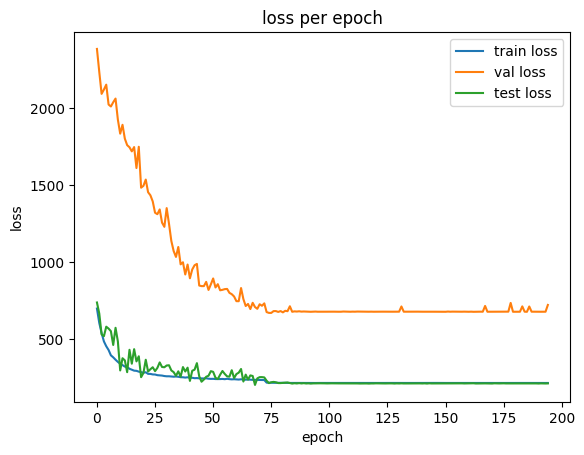

In [ ]:
plt.plot(train_losses[5:], label='train loss')
plt.plot(val_losses[5:], label='val loss')
plt.plot(test_losses[5:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

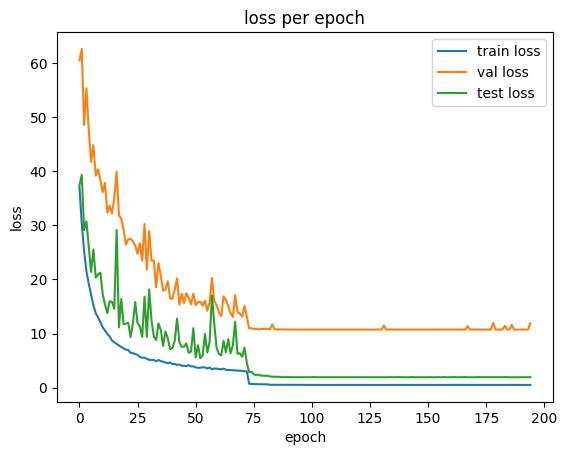

In [ ]:
plt.plot(len_train_losses[5:], label='train loss')
plt.plot(len_val_losses[5:], label='val loss')
plt.plot(len_test_losses[5:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
len_train_losses[5:it].min()*49/4

5.945886852210149

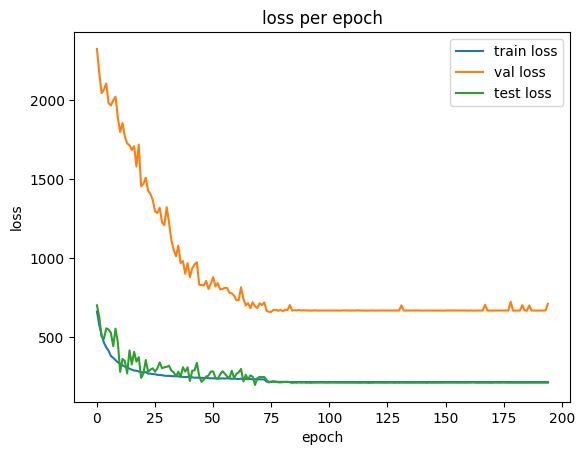

In [ ]:
plt.plot(train_losses[5:] - len_train_losses[5:], label='train loss')
plt.plot(val_losses[5:] - len_val_losses[5:], label='val loss')
plt.plot(test_losses[5:] - len_test_losses[5: ], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
best_test_loss

203.463734611136

In [ ]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [ ]:
RMSE_loss = RMSE_compute(L_tar, L_pred)
nRMSE_loss = nRMSE_compute(L_tar, L_pred)
r2_m = r2_compute(L_tar, L_pred)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 45.43718719482422, nRMSE: 0.03932800155229083, r2: 0.9939481627978345


In [ ]:
L_v_tar, L_v_pred = L_Pred(Test_List, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

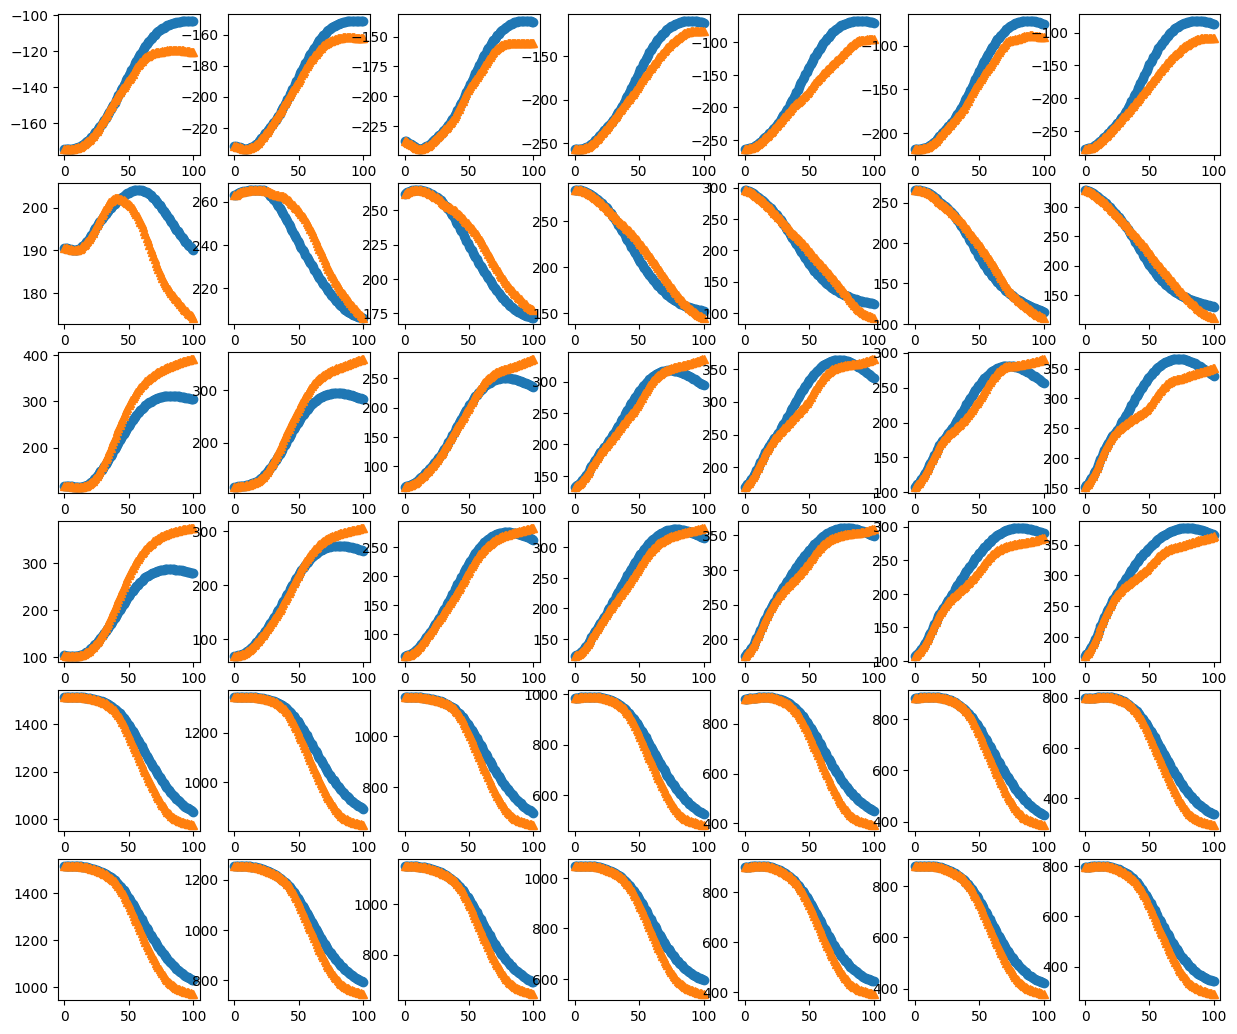

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [ ]:
np.where(test_losses == best_test_loss)

(array([73]),)

# Best MSE


In [22]:
# Load best val model
model = TransformerBased(49, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "last_model_params.pt"), map_location=torch.device('cpu')))
model.eval()

C:\Users\Remote\AppData\Local\Temp\ipykernel_15944\3899656445.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path_to_folde

TransformerBased(
  (dim_expander): Linear(in_features=49, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [23]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [25]:
RMSE_loss = RMSE_compute(L_tar, L_pred, Test_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar, L_pred, my_range, Test_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar, L_pred)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 45.437255859375, nRMSE: 0.03932803571570909, r2: 0.9939481446138504


## Segment Calculation

In [26]:
def bin_calculator(target_df):
  bins = {}
  for item in target_df.columns:
    q1 = target_df[item].quantile(0.25)
    q3 = target_df[item].quantile(0.75)
    iqr = q3-q1
    h = 2 * iqr * (len(target_df) ** (-1/3))
    num_bins = (target_df[item].max() - target_df[item].min()) / h
    bins[item] = round(num_bins)
  return bins

In [71]:
def seg_cons(L_selected, seg_indexes, label):
    L_t = pd.DataFrame(L_selected.numpy())
    arm = L_t.iloc[:, seg_indexes].copy()
    dx = arm[seg_indexes[0]]-arm[seg_indexes[1]]
    dy = arm[seg_indexes[2]]-arm[seg_indexes[3]]
    dz = arm[seg_indexes[4]]-arm[seg_indexes[5]]

    arm['dx'] = dx
    arm['dy'] = dy
    arm['dz'] = dz
    arm = arm.drop(columns = seg_indexes)
    # arm_len = np.sqrt((arm**2).sum(axis=1).iloc[:101])
    arm_len = np.sqrt((arm**2).sum(axis=1))
    plt.subplot(2, 1, 1)
    plt.plot(arm_len)
    plt.title(label)
    print(f"mean: {arm_len.mean():.2f}, std: {arm_len.std():.2f}")
    arm_len_bins = bin_calculator(pd.DataFrame(arm_len))
    plt.subplot(2, 1, 2)
    plt.hist(arm_len, bins=arm_len_bins[0], edgecolor='black')
    plt.show()


    # return arm_len


mean: 286.09, std: 7.93


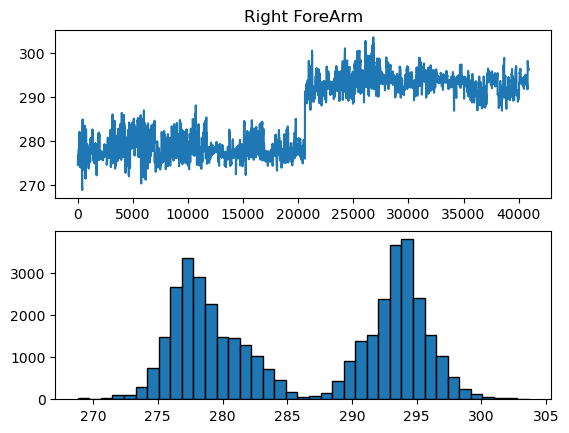

In [72]:
# Right ForeArm True
seg_cons(L_tar, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 289.29, std: 17.33


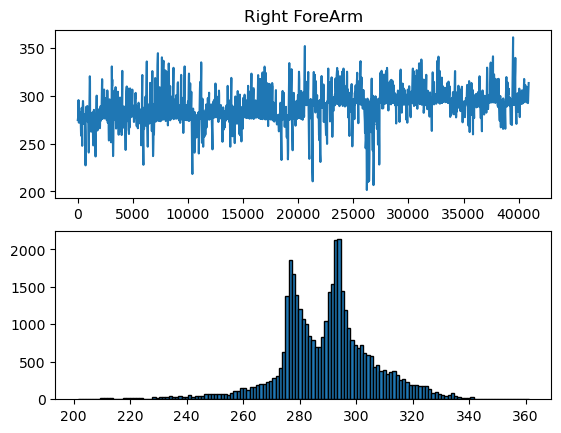

In [73]:
# Right ForeArm Prediction
seg_cons(L_pred, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 361.25, std: 16.39


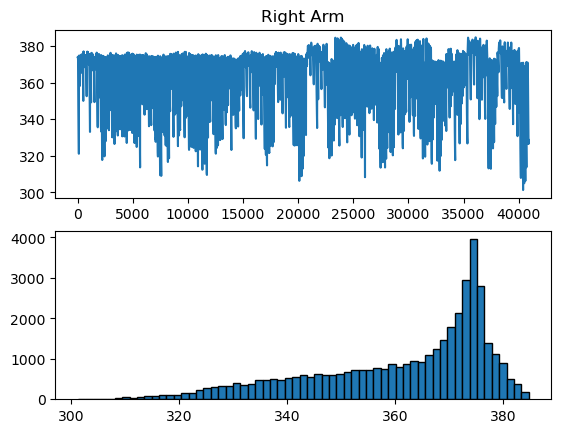

In [74]:
# Right Arm True
seg_cons(L_tar, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 365.32, std: 19.91


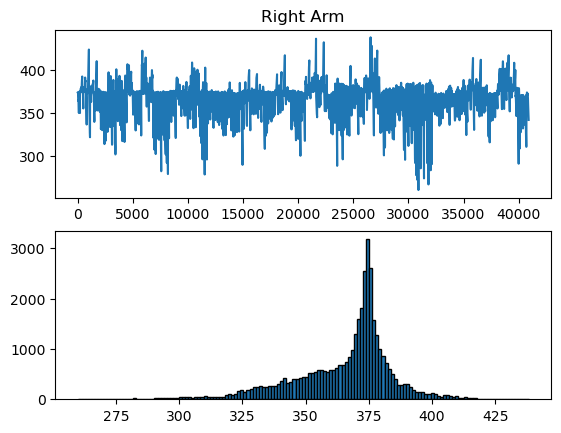

In [75]:
# Right Arm Predicted
seg_cons(L_pred, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 286.09, std: 7.93


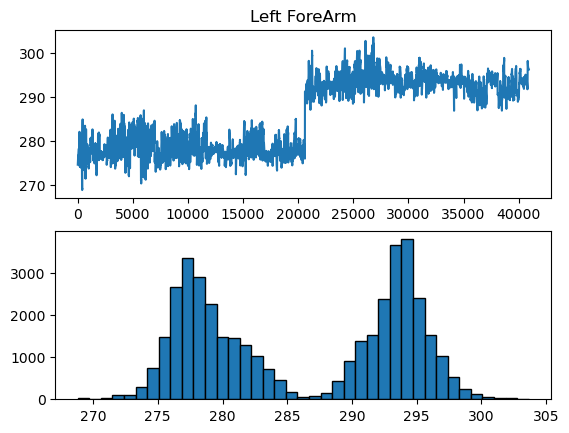

In [76]:
# Left ForeArm True
seg_cons(L_tar, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 289.29, std: 17.33


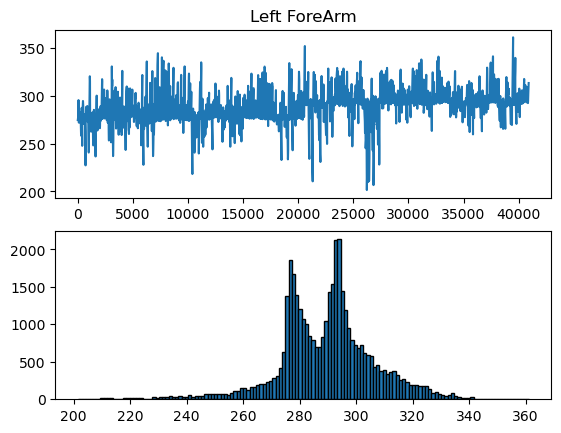

In [77]:
# Left ForeArm Prediction
seg_cons(L_pred, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 361.25, std: 16.39


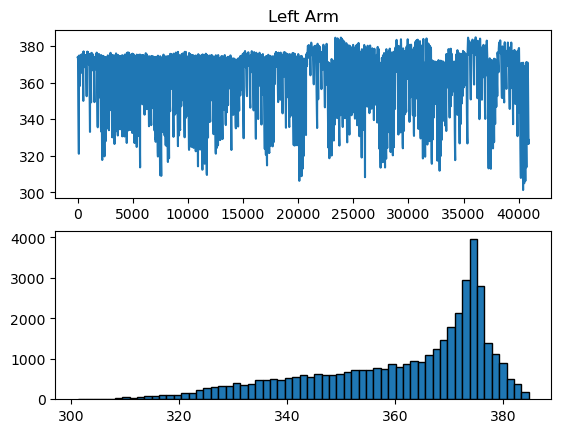

In [78]:
# Left Arm True
seg_cons(L_tar, [7, 9, 21, 23, 35, 37], 'Left Arm')

mean: 365.32, std: 19.91


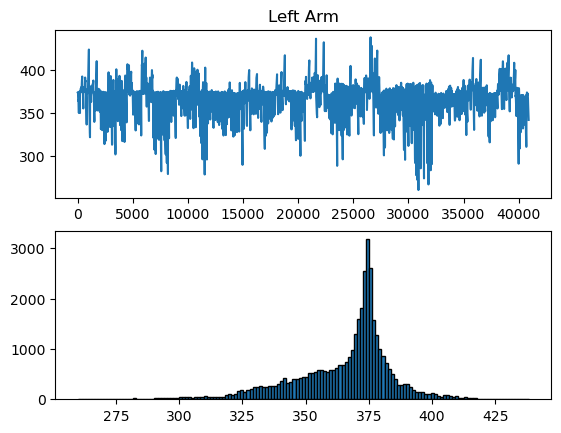

In [79]:
# Left Arm Prediction
seg_cons(L_pred, [7, 9, 21, 23, 35, 37], 'Left Arm')

### One test subject: test subject 1

In [80]:
i = 0
L_tar_test_sub_1 = torch.zeros(101*len(Test_1_List), segment_len)
L_pred_test_sub_1 = torch.zeros(101*len(Test_1_List), segment_len)
for j in range(len(Test_1_List)):
    L_v_tar, L_v_pred = L_Pred(Test_1_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar_test_sub_1[0+i:101+i, :] = L_v_tar
    L_pred_test_sub_1[0+i:101+i, :] = L_v_pred
    i = i + 101

In [81]:
RMSE_loss = RMSE_compute(L_tar_test_sub_1, L_pred_test_sub_1, Test_1_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar_test_sub_1, L_pred_test_sub_1, my_range, Test_1_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar_test_sub_1, L_pred_test_sub_1)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 46.65187072753906, nRMSE: 0.039026330580738955, r2: 0.9934812630775132


mean: 278.62, std: 2.68


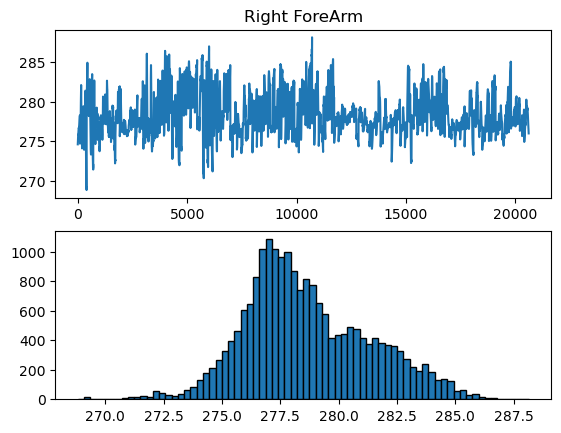

In [82]:
# Right ForeArm True
seg_cons(L_tar_test_sub_1, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 283.57, std: 16.00


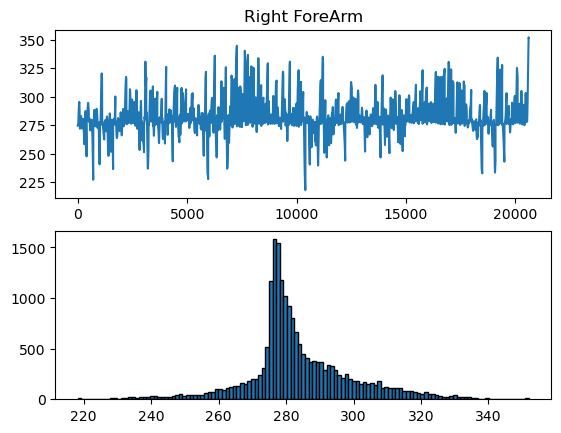

In [83]:
# Right ForeArm Prediction
seg_cons(L_pred_test_sub_1, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 359.59, std: 16.06


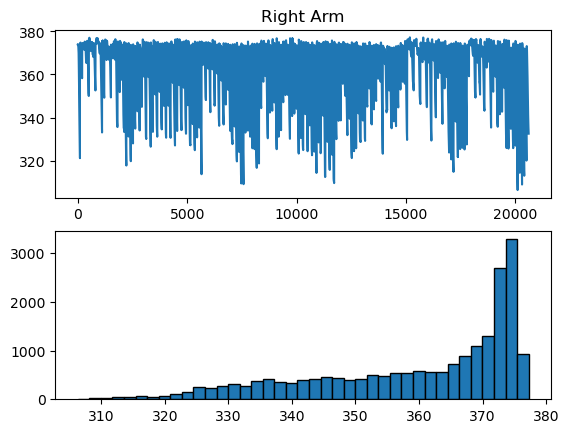

In [84]:
# Right Arm True
seg_cons(L_tar_test_sub_1, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 364.40, std: 19.24


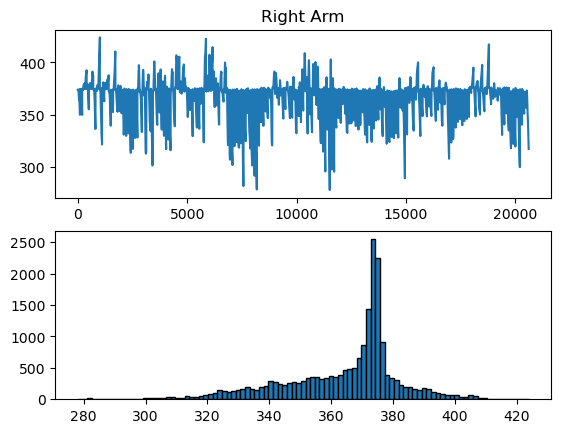

In [85]:
# Right Arm Predicted
seg_cons(L_pred_test_sub_1, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 278.62, std: 2.68


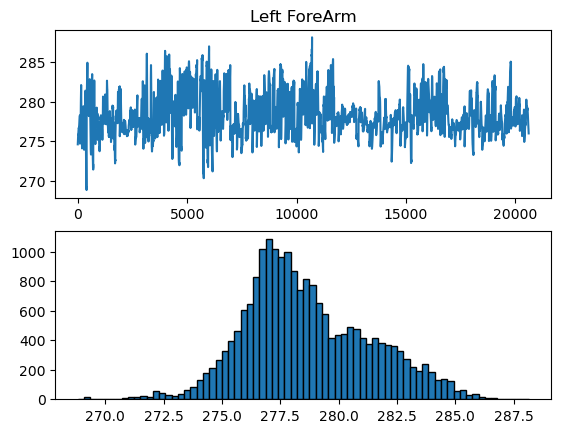

In [86]:
# Left ForeArm True
seg_cons(L_tar_test_sub_1, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 283.57, std: 16.00


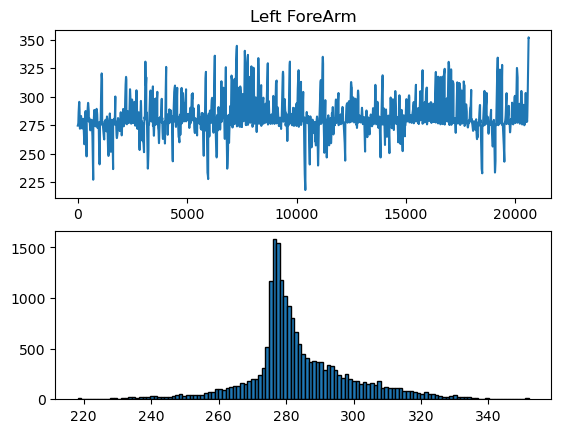

In [87]:
# Left ForeArm Prediction
seg_cons(L_pred_test_sub_1, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 359.59, std: 16.06


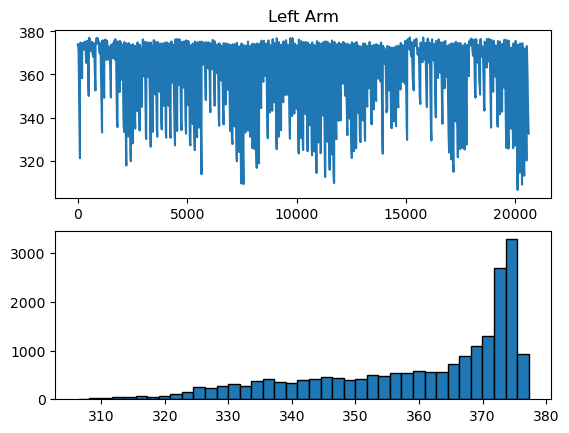

In [88]:
# Left Arm True
seg_cons(L_tar_test_sub_1, [7, 9, 21, 23, 35, 37], 'Left Arm')

mean: 364.40, std: 19.24


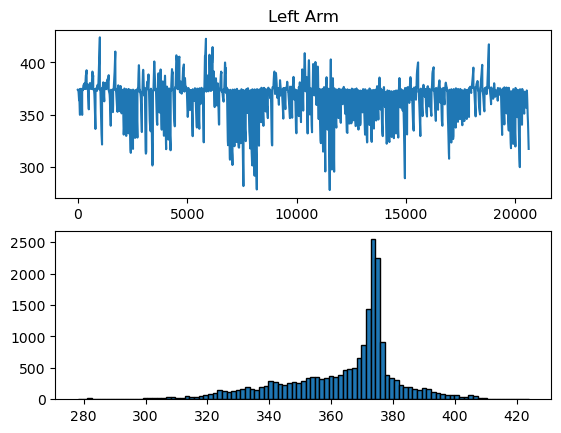

In [89]:
# Left Arm Prediction
seg_cons(L_pred_test_sub_1, [7, 9, 21, 23, 35, 37], 'Left Arm')

### One test subject: test subject 2

In [90]:
i = 0
L_tar_test_sub_2 = torch.zeros(101*len(Test_2_List), segment_len)
L_pred_test_sub_2 = torch.zeros(101*len(Test_2_List), segment_len)
for j in range(len(Test_2_List)):
    L_v_tar, L_v_pred = L_Pred(Test_2_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar_test_sub_2[0+i:101+i, :] = L_v_tar
    L_pred_test_sub_2[0+i:101+i, :] = L_v_pred
    i = i + 101

In [91]:
RMSE_loss = RMSE_compute(L_tar_test_sub_2, L_pred_test_sub_2, Test_2_List, input_frames, segment_len, device)
nRMSE_loss = nRMSE_compute(L_tar_test_sub_2, L_pred_test_sub_2, my_range, Test_2_List, input_frames, segment_len, device)
r2_m = r2_compute(L_tar_test_sub_2, L_pred_test_sub_2)
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 44.170372009277344, nRMSE: 0.039631895519419834, r2: 0.9944020092816864


mean: 293.67, std: 2.29


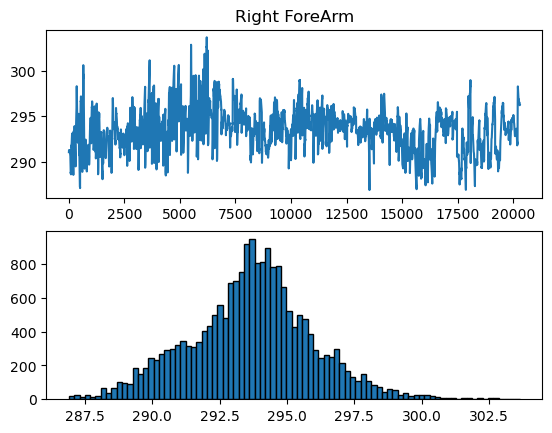

In [92]:
# Right ForeArm True
seg_cons(L_tar_test_sub_2, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 295.09, std: 16.70


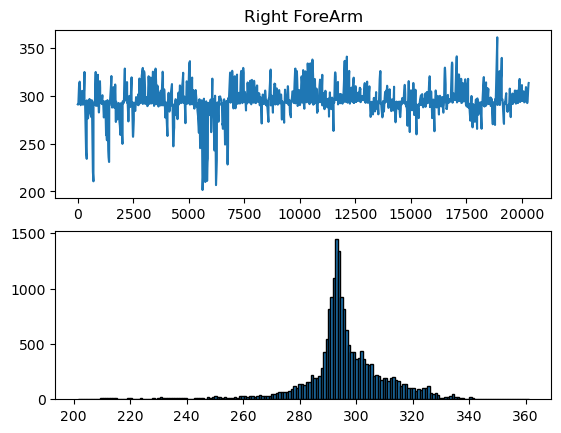

In [93]:
# Right ForeArm Prediction
seg_cons(L_pred_test_sub_2, [9, 11, 23, 25, 37, 39], 'Right ForeArm')

mean: 362.94, std: 16.55


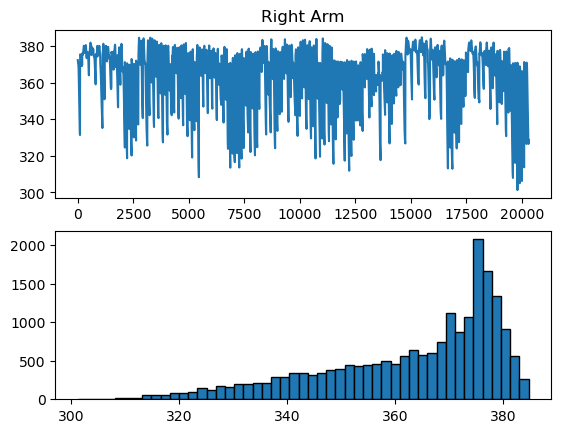

In [94]:
# Right Arm True
seg_cons(L_tar_test_sub_2, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 366.26, std: 20.53


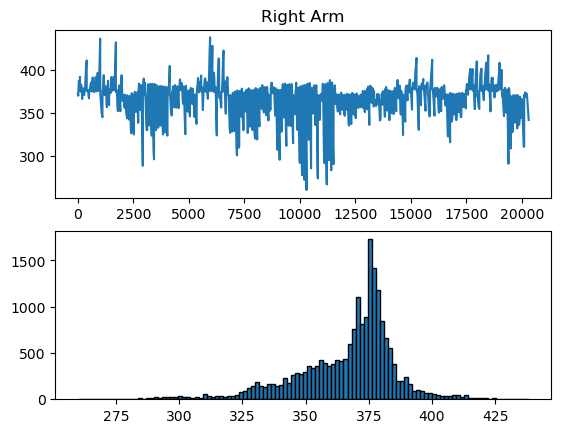

In [95]:
# Right Arm Predicted
seg_cons(L_pred_test_sub_2, [7, 9, 21, 23, 35, 37], 'Right Arm')

mean: 293.67, std: 2.29


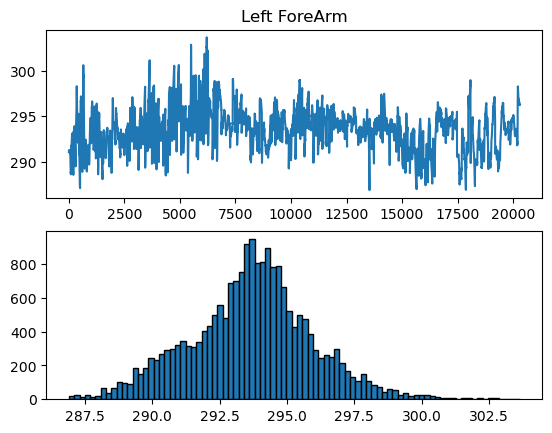

In [96]:
# Left ForeArm True
seg_cons(L_tar_test_sub_2, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 295.09, std: 16.70


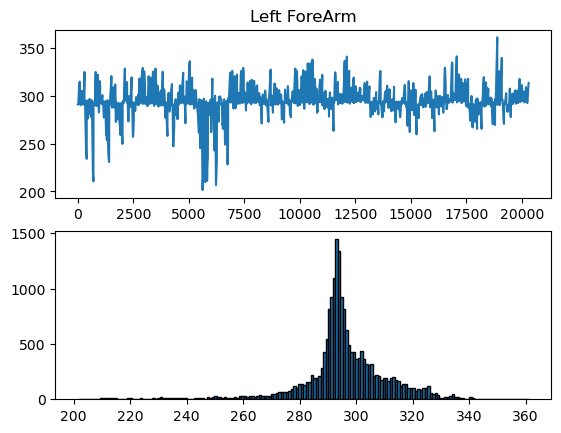

In [97]:
# Left ForeArm Prediction
seg_cons(L_pred_test_sub_2, [9, 11, 23, 25, 37, 39], 'Left ForeArm')

mean: 362.94, std: 16.55


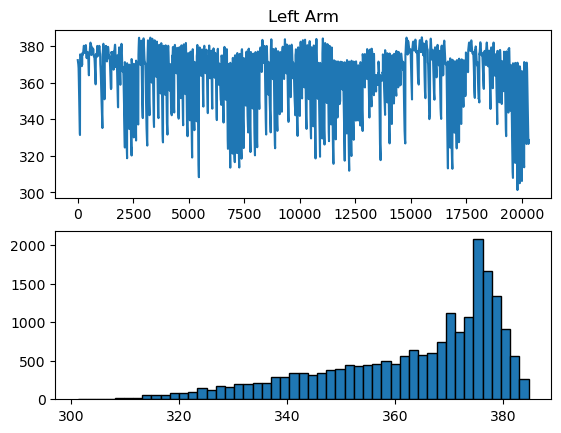

In [98]:
# Left Arm True
seg_cons(L_tar_test_sub_2, [7, 9, 21, 23, 35, 37], 'Left Arm')

mean: 366.26, std: 20.53


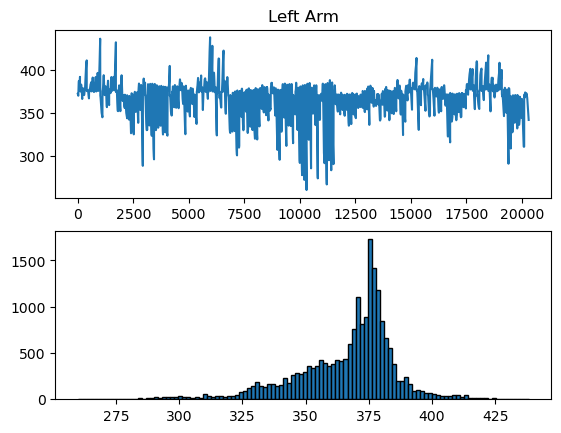

In [99]:
# Left Arm Prediction
seg_cons(L_pred_test_sub_2, [7, 9, 21, 23, 35, 37], 'Left Arm')

In [44]:
my_path_list[36]

'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s13_fn\\s13_133_fn.csv'

In [47]:
L_v_tar, L_v_pred = L_Pred(Test_List, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

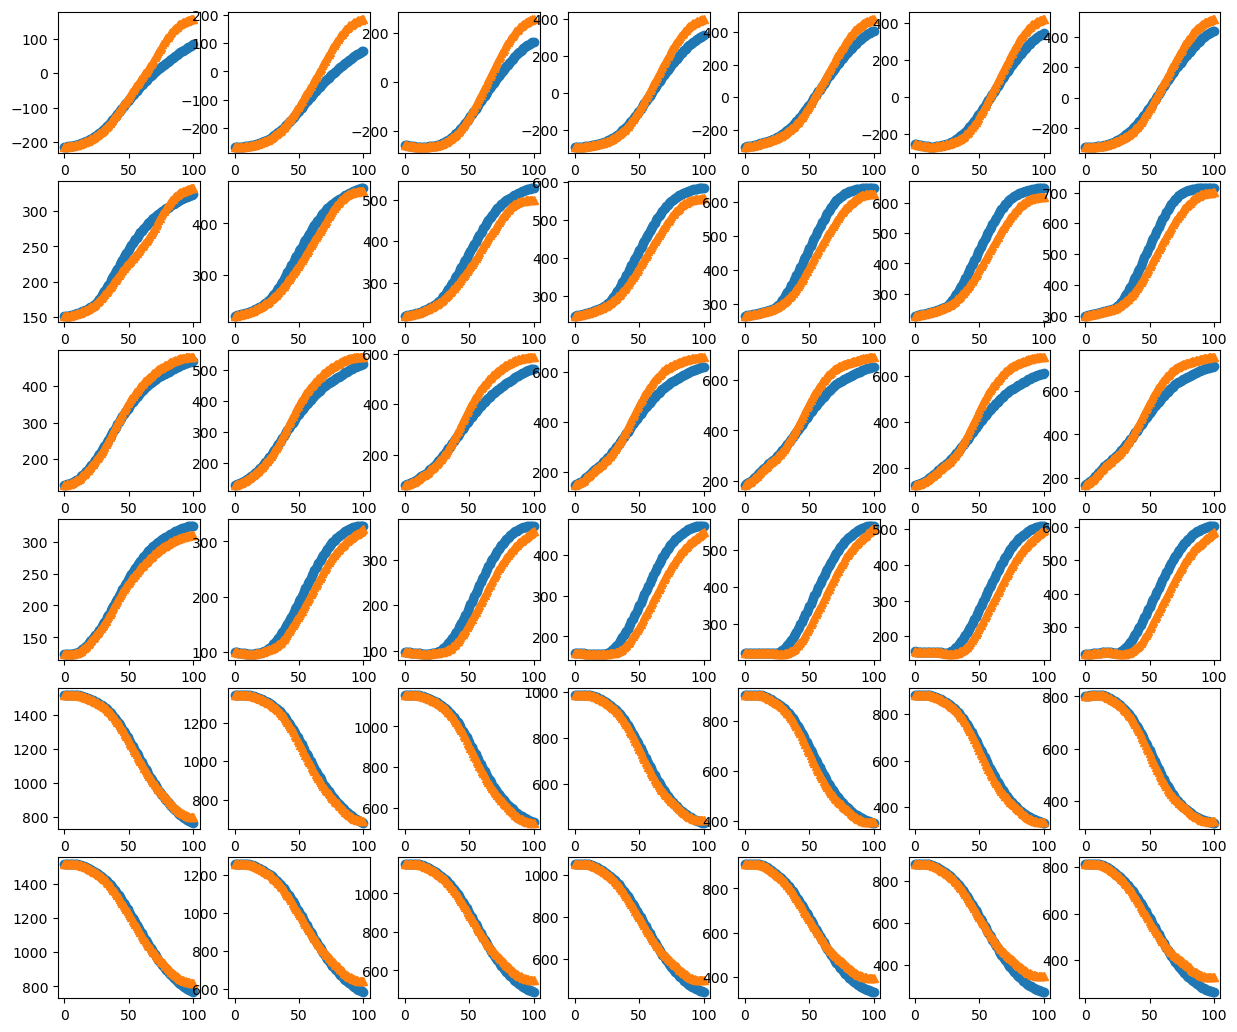

In [48]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

# Export Results

In [49]:
tartar = pd.DataFrame(L_v_tar.cpu().squeeze())
tartar

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-213.184845,-265.412628,-256.338989,-289.812195,-303.227661,-252.056732,-320.277893,152.097061,221.446838,219.834106,...,902.393311,882.089905,801.194092,1519.498535,1258.163208,1152.702881,1053.290649,911.127686,883.225342,812.008423
1,-212.871384,-265.563721,-257.556824,-289.854431,-302.000031,-253.911255,-320.530212,152.038879,221.948807,220.272049,...,902.831421,882.293091,801.683044,1519.585205,1258.296509,1152.843506,1053.406616,911.308105,883.381775,812.223999
2,-212.531952,-265.686584,-258.731445,-289.888550,-300.797424,-255.679016,-320.732849,152.025925,222.456177,220.727371,...,903.253662,882.502808,802.183044,1519.655029,1258.421265,1152.973145,1053.527344,911.487122,883.534058,812.447083
3,-212.136963,-265.749634,-259.824554,-289.889313,-299.608521,-257.299683,-320.835571,152.098557,222.978134,221.223602,...,903.634277,882.709045,802.694763,1519.676514,1258.514160,1153.065918,1053.637695,911.645508,883.661072,812.663818
4,-211.664856,-265.728058,-260.807312,-289.819153,-298.387024,-258.761963,-320.807709,152.281143,223.520523,221.779831,...,903.953369,882.895569,803.221863,1519.624634,1258.555176,1153.101074,1053.719360,911.765747,883.743286,812.857300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,152.960190,180.022186,247.515045,391.259521,470.000397,413.573639,506.071350,330.795532,462.140991,498.870544,...,393.038544,336.451050,322.144714,824.906616,644.941772,553.453369,499.479218,395.296753,345.136841,326.583771
97,154.143890,181.727203,250.004822,394.185486,473.119598,416.620880,509.488098,331.361847,462.539734,499.183380,...,392.897095,335.906189,322.165131,823.153870,643.547607,552.289246,498.808411,395.079041,344.645386,326.464020
98,155.262115,183.340393,252.347656,396.966492,476.082367,419.521332,512.699890,331.881500,462.905945,499.497528,...,393.057281,335.637665,322.404877,821.723877,642.484497,551.441162,498.434998,395.131653,344.434631,326.643799
99,156.316437,184.865631,254.559631,399.607056,478.897186,422.283417,515.714417,332.356110,463.243225,499.817566,...,393.462189,335.597565,322.814331,820.565063,641.700317,550.855591,498.309570,395.405884,344.450470,327.065521


In [50]:
tartar.to_csv('arm_tar.csv')

In [51]:
per = pd.DataFrame(L_v_pred.cpu().squeeze())
per

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-213.184845,-265.412628,-256.338989,-289.812195,-303.227661,-252.056732,-320.277893,152.097061,221.446838,219.834106,...,902.393311,882.089905,801.194092,1519.498535,1258.163208,1152.702881,1053.290649,911.127686,883.225342,812.008423
1,-212.871384,-265.563721,-257.556824,-289.854431,-302.000031,-253.911255,-320.530212,152.038879,221.948807,220.272049,...,902.831421,882.293091,801.683044,1519.585205,1258.296509,1152.843506,1053.406616,911.308105,883.381775,812.223999
2,-212.531952,-265.686584,-258.731445,-289.888550,-300.797424,-255.679016,-320.732849,152.025925,222.456177,220.727371,...,903.253662,882.502808,802.183044,1519.655029,1258.421265,1152.973145,1053.527344,911.487122,883.534058,812.447083
3,-212.136963,-265.749634,-259.824554,-289.889313,-299.608521,-257.299683,-320.835571,152.098557,222.978134,221.223602,...,903.634277,882.709045,802.694763,1519.676514,1258.514160,1153.065918,1053.637695,911.645508,883.661072,812.663818
4,-211.664856,-265.728058,-260.807312,-289.819153,-298.387024,-258.761963,-320.807709,152.281143,223.520523,221.779831,...,903.953369,882.895569,803.221863,1519.624634,1258.555176,1153.101074,1053.719360,911.765747,883.743286,812.857300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,74.612762,63.210098,151.534698,297.379089,391.238983,329.886719,421.589722,321.021057,466.118530,525.445557,...,396.766907,338.510590,321.317017,782.258545,597.964233,499.636322,451.697235,337.386902,277.667419,269.929443
97,76.780975,65.790649,154.924011,301.349701,395.584076,334.219116,426.593140,321.738525,466.959229,526.334595,...,394.993378,336.654297,320.096283,778.126770,594.454163,496.476624,449.129517,335.413330,275.403748,268.171021
98,78.862122,68.235031,158.086761,305.000214,399.568268,338.210968,431.187256,322.413330,467.742706,527.154907,...,393.385345,334.970001,319.008118,774.324768,591.223694,493.575317,446.803589,333.661804,273.374390,266.631836
99,80.855133,70.543671,161.027222,308.338013,403.200470,341.871002,435.381470,323.046875,468.473206,527.912842,...,391.938782,333.452942,318.048737,770.846375,588.265015,490.925049,444.711243,332.123962,271.570984,265.302490


In [52]:
per.to_csv('arm_per.csv')

In [53]:
my_path_list[200]

'C:/Niloofar/SCR/posture-prediction-models-main/data/data_20_4_2025/Normalized\\s13_fn\\s13_97_fn.csv'